<a href="https://colab.research.google.com/github/Kaz-K/medical-ai-radiology/blob/master/notebooks/convolution_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 医用画像処理の基本

本資料はメディカルAI学会公認資格講座における医用画像解析「放射線画像」のための<u>**非公認**</u>の補足資料です。

**深層畳み込みニューラルネットワークの基礎**についてソース・コードと共に解説します。

## 環境のセットアップ

### ライブラリのインストール

初めに、本補足資料において必要なPythonライブラリをインストールします。ライブラリは以下の通りです。

- **matplotlib** : 図表を可視化するためのライブラリ

In [1]:
!pip install matplotlib

## サンプル画像のダウンロード

次のスクリプトを実行すると、Google colab上のホームディレクトリに`chest-xray.jpg`というファイル名でサンプル用の胸部X線写真がダウンロードされます。

注意：サンプル用のDICOM画像は以下のURLより取得したものを、Google colabからアクセス可能なGithub上のファイルとして配置し直したものです。

Chest radiograph - Wikipedia : https://en.wikipedia.org/wiki/Chest_radiograph

In [2]:
!curl -L -O https://github.com/Kaz-K/medical-ai-radiology/releases/download/v0.1/chest-xray.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   605    0   605    0     0   3025      0 --:--:-- --:--:-- --:--:--  3040
100  479k  100  479k    0     0   586k      0 --:--:-- --:--:-- --:--:-- 1184k


早速、画像ファイルを可視化して確認します。

画像ファイルをNumPy配列として読み込むことの出来る`imageio`を利用します。更に、元画像の解像度が`(2197, 1920)`と大きいため、以下の解説における計算時間を短縮する目的で、配列を画像として処理することの出来るライブラリ`scipy.ndimage`を用いてこれを0.5倍となる`(1098, 960)`に縮小します。

元画像の解像度:  (2197, 1920)
縮小後の解像度:  (1098, 960)


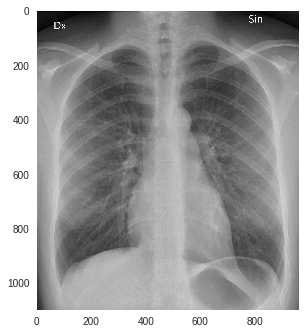

In [3]:
import imageio 
import scipy.ndimage
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
image = imageio.imread('chest-xray.jpg', pilmode='L')
print('元画像の解像度: ', image.shape)
image = scipy.ndimage.zoom(image, 0.5)
print('縮小後の解像度: ', image.shape)
ax.imshow(image, cmap='gray')
plt.grid(False)
plt.show()

## 畳み込み演算の基本

**畳み込み(Convolution)**とは、画像よりも小さなサイズを持つカーネル（あるいはフィルタ）と呼ばれる行列を用意し、画像の各画素に対してフィルタの中心を重ね、重なった領域全体に渡って画素とフィルタの内積を計算する演算を言います。

これは、数式として次のように表すことが出来ます。

ここで、（数式の説明）

尚、畳み込みによる画像演算において、主に次の3つのパラメータが出力に関係することに注意して下さい。

- **kernel_size** : 
- **stride** : 
- **padding** :  

次の関数`convolve2d`は`kernel_size=3, stride=1, padding=1`の条件で画像に対する畳み込みを行うものになります。

---
`convolve2d`は以下のサイトからコードを借用していますが、他にも畳み込みの図式的な説明などもありますので参考にしてみて下さい。

参考 : http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html![image.png](attachment:image.png)

In [0]:
def convolve2d(image, kernel):
    kernel = np.flipud(np.fliplr(kernel))    # Flip the kernel
    output = np.zeros_like(image)            # convolution output
    # Add zero padding to the input image
    image_padded = np.zeros((image.shape[0] + 2, image.shape[1] + 2))   
    image_padded[1:-1, 1:-1] = image
    for x in range(image.shape[1]):     # Loop over every pixel of the image
        for y in range(image.shape[0]):
            # element-wise multiplication of the kernel and the image
            output[y, x]=(kernel * image_padded[y:y+3, x:x+3]).sum()        
    return output

以後、サンプル画像とその一部の少領域（以下、パッチ領域と呼びます）にそれぞれ注目し、個々のカーネルを用いた畳み込みによってどのように画像が変換されるのかを確認していきます。

まず、サンプル画像とそのパッチ領域を並べて表示するための関数を用意します。このとき、パッチ領域に対しては画素値に相当する数値を画像の上に重ねて表示させることで、それぞれの計算過程でピクセル値がどう変化するのかを確かめ易くすることとします。

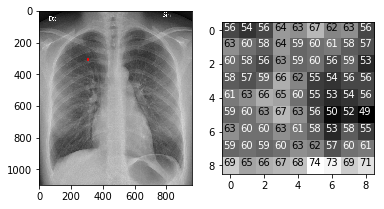

In [0]:
import matplotlib.patches as patches

def show_image_with_patch(image, x=300, y=300, width=9, height=9):
    fig = plt.figure()
    ax = fig.add_subplot(121)
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor=None)
    ax.add_patch(rect)
    ax.imshow(image, cmap='gray')
   
    ax = fig.add_subplot(122)
    image_patch = image[x: x + width, y: y + height]
    ax.imshow(image_patch, cmap='gray')
    threshold = (image_patch.max() - image_patch.min()) / 2 + image_patch.min()
    for x in range(width):
        for y in range(height):
            val = round(image_patch[x][y], 2) if image_patch[x][y] != 0 else 0 
            ax.annotate(str(val), 
                        xy=(y - 0.4, x), 
                        color='white' if image_patch[x][y] < threshold else 'black')
    plt.show()
    
show_image_with_patch(image)

続いて、各種の画像変換を行うためのカーネルを定めます。名前のついたカーネルは数多くありますが、次のURLにその代表的なものが紹介されていますので、参考にして下さい。

参考URL :

identity


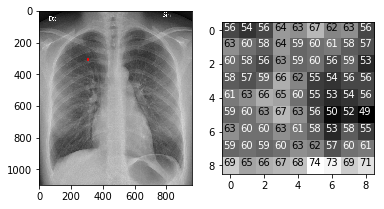

edge_detection


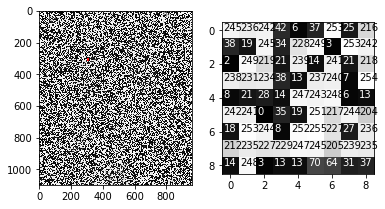

sharpen


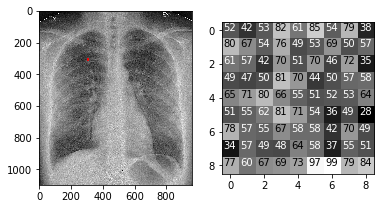

gaussian_blur


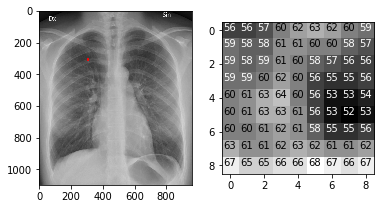

vertical


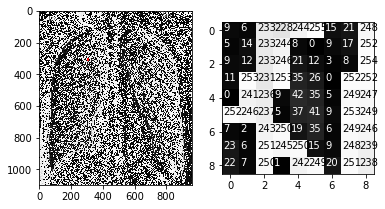

horizontal


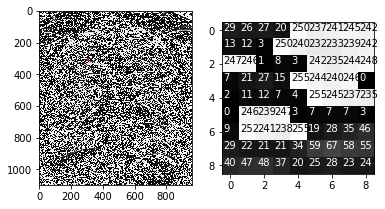

In [0]:
import numpy as np 

print('identity')
identity = np.array([[0, 0, 0], 
                     [0, 1, 0],
                     [0, 0, 0]])

show_image_with_patch(convolve2d(image, identity))

print('edge_detection')
edge_detection = np.array([[-1, -1, -1],
                           [-1, 8, -1],
                           [-1, -1, -1]])

show_image_with_patch(convolve2d(image, edge_detection))

print('sharpen')
sharpen = np.array([[0, -1, 0], 
                    [-1, 5, -1],
                    [0, -1, 0]])

show_image_with_patch(convolve2d(image, sharpen))

print('gaussian_blur')
gaussian_blur = np.array([[1, 2, 1],
                          [2, 4, 2],
                          [1, 2, 1]]) * (1./16.)

show_image_with_patch(convolve2d(image, gaussian_blur))

print('vertical')
vertical = np.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])

show_image_with_patch(convolve2d(image, vertical))

print('horizontal')
horizontal = np.array([[1, 2, 1],
                       [0, 0, 0],
                       [-1, -2, -1]])

show_image_with_patch(convolve2d(image, horizontal))

以上の結果から、畳み込みによって**エッジの検出**、**先鋭化**、**ぼかし**、更には**特定の方向に対して輝度値が変化している部分の検出**などの多様な画像変換が可能になることが確認できます。

## 深層畳み込みニューラルネットワークの基礎

In [0]:
import torch